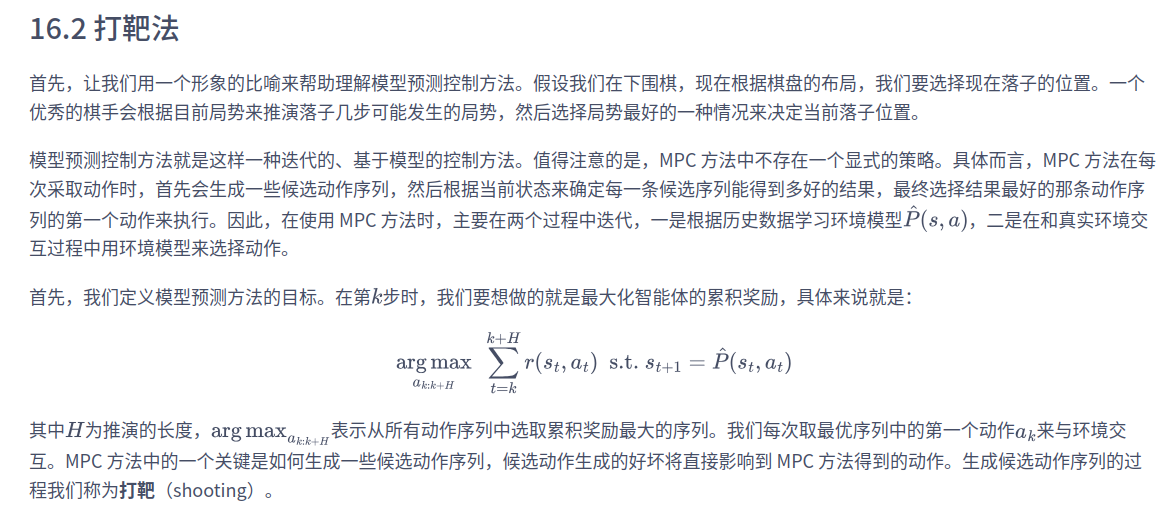

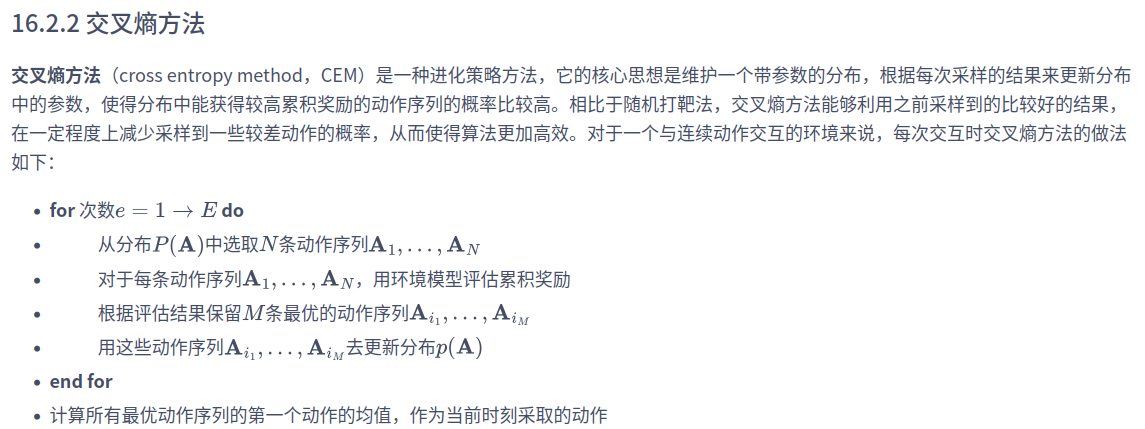  
$$c\_var = min( min( (\frac{(\mu - lb)}{2})^2, (\frac{(ub - \mu)}{2})^2), var )$$
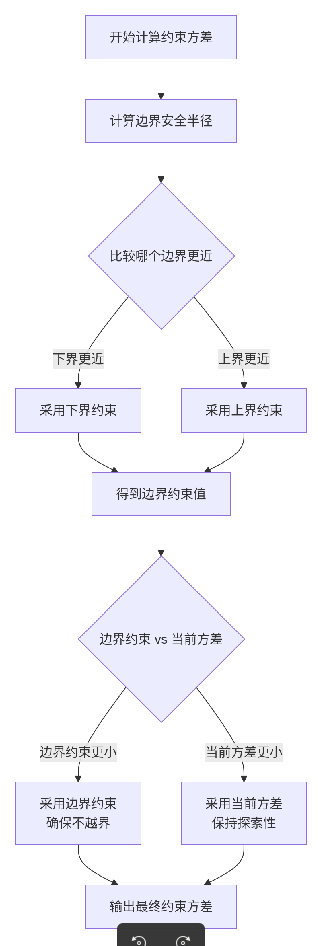

In [ ]:
import numpy as np
from scipy.stats import truncnorm
import gymnasium as gym
import itertools
import torch
import torch.nn as nn
import torch.nn.functional as F
import collections
import matplotlib.pyplot as plt


class CEM:
    def __init__(self, n_sequence, elite_ratio, fake_env, upper_bound,
                 lower_bound):
        self.n_sequence = n_sequence
        self.elite_ratio = elite_ratio
        self.upper_bound = upper_bound
        self.lower_bound = lower_bound
        self.fake_env = fake_env

    def optimize(self, state, init_mean, init_var):
        # mean的形状通常是 (action_dim,)，可能(H * a_dim,）,H为规划步数（时间步数）
        mean, var = init_mean, init_var
        # 正态分布[-inf,inf]->[-2,2],(action_dim,)
        X = truncnorm(-2, 2, loc=np.zeros_like(mean), scale=np.ones_like(var))
        state = np.tile(state, (self.n_sequence, 1))
        # (state_dim,)->(1,state_dim)->(n_sequence,state_dim)
        for _ in range(5):
            lb_dist, ub_dist = mean - self.lower_bound, self.upper_bound - mean
            constrained_var = np.minimum(np.minimum(np.square(lb_dist / 2), np.square(ub_dist / 2)),var)
            # 生成动作序列，一个随机变量乘以一个常数 a，其方差将变为原来的 a²倍
            # X.rvs()从定义好的概率分布中生成随机样本(action_dim,)
            action_sequences = [X.rvs() for _ in range(self.n_sequence)] * np.sqrt(constrained_var) + mean
            # (n_sequence,action_dim)+(action_dim,)->(n_sequence,action_dim)
            # (action_dim,)->(1,action_dim)->(n_sequence,action_dim)
            # 计算每条动作序列的累积奖励
            returns = self.fake_env.propagate(state, action_sequences)[:, 0]
            # (n_sequence,）
            # 选取累积奖励最高的若干条动作序列
            n_elites = int(self.elite_ratio * self.n_sequence)
            # 计算精英序列数量
            elite_indices = np.argsort(returns)[-n_elites:]
            # 现在动作序列按奖励从低到高排列
            elites = action_sequences[elite_indices]
            # 选择排序后最后 n_elites 个序列（即奖励最高的那些）
            new_mean = np.mean(elites, axis=0)
            new_var = np.var(elites, axis=0)
            # 更新动作序列分布
            mean = 0.1 * mean + 0.9 * new_mean
            var = 0.1 * var + 0.9 * new_var
        return mean
        # (H * a_dim,）

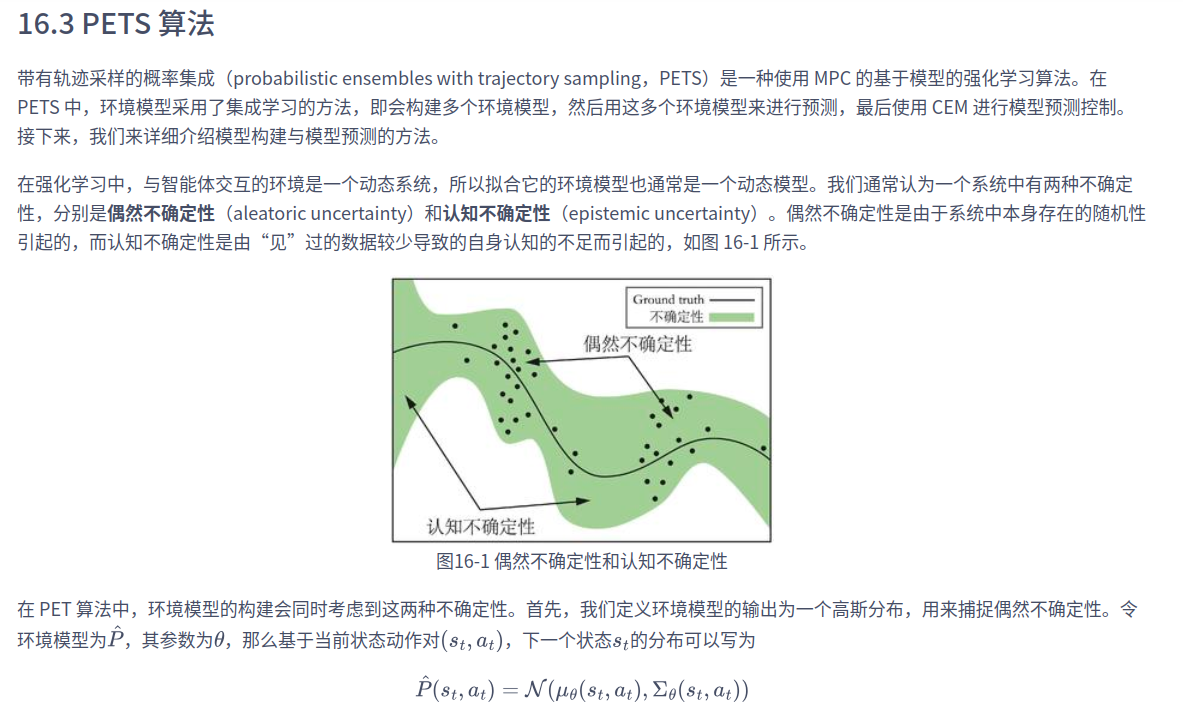  
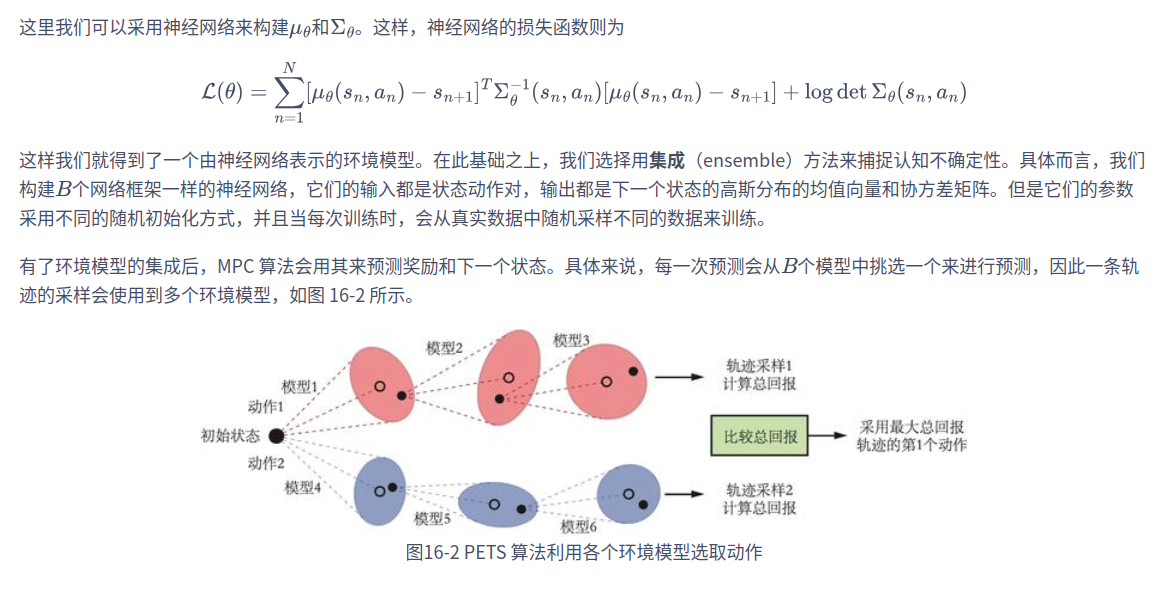  

In [35]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")


class Swish(nn.Module):
    ''' Swish激活函数 '''
    def __init__(self):
        super(Swish, self).__init__()

    def forward(self, x):
        return x * torch.sigmoid(x)


def init_weights(m):
    ''' 初始化模型权重 '''
    def truncated_normal_init(t, mean=0.0, std=0.01):
        torch.nn.init.normal_(t, mean=mean, std=std)
        while True:
            cond = (t < mean - 2 * std) | (t > mean + 2 * std)
            # |操作符执行的是逐元素的逻辑或操作
            # 返回布尔张量
            if not torch.sum(cond):
                # 返回的是张量 cond中 True值的数量
                # 表示全在范围内
                break
            t = torch.where(cond,
                torch.nn.init.normal_(torch.ones(t.shape, device=device),mean=mean,std=std), t)
        return t

    if type(m) == nn.Linear or isinstance(m, FCLayer):
        truncated_normal_init(m.weight, std=1 / (2 * np.sqrt(m._input_dim)))
        m.bias.data.fill_(0.0)


class FCLayer(nn.Module):
    ''' 集成之后的全连接层 '''
    def __init__(self, input_dim, output_dim, ensemble_size, activation):
        super(FCLayer, self).__init__()
        self._input_dim, self._output_dim = input_dim, output_dim
        self.weight = nn.Parameter(torch.Tensor(ensemble_size, input_dim, output_dim).to(device))
        self.bias = nn.Parameter(torch.Tensor(ensemble_size, output_dim).to(device))
        self._activation = activation

    def forward(self, x):
        # x 的形状应该是: (ensemble_size, batch_size, input_dim)
        # 例如：5个模型，批量大小32，输入维度10
        return self._activation(torch.add(torch.bmm(x, self.weight), self.bias[:, None, :]))

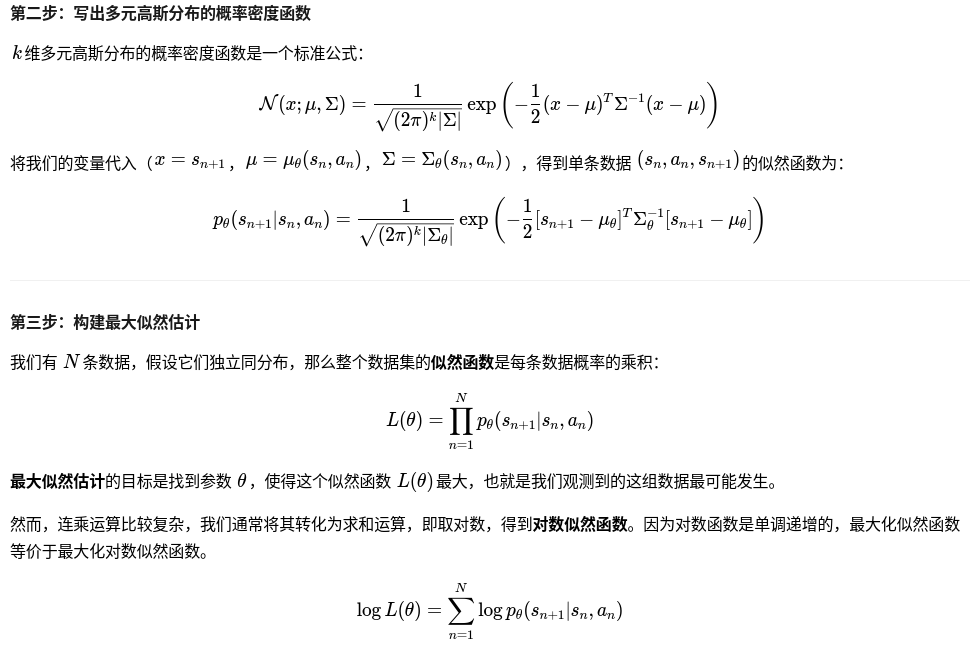  
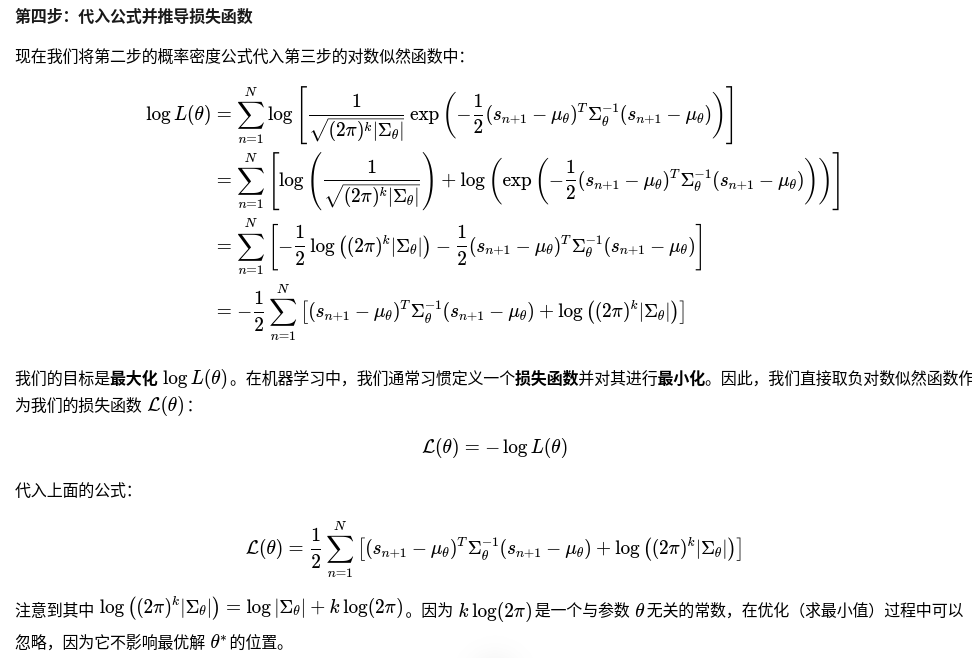  
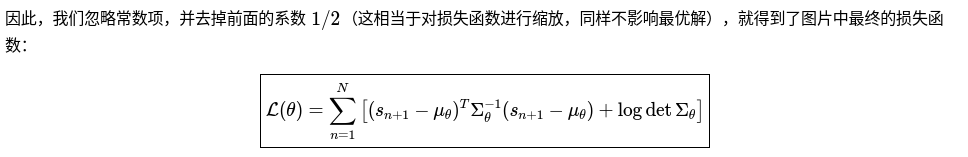  
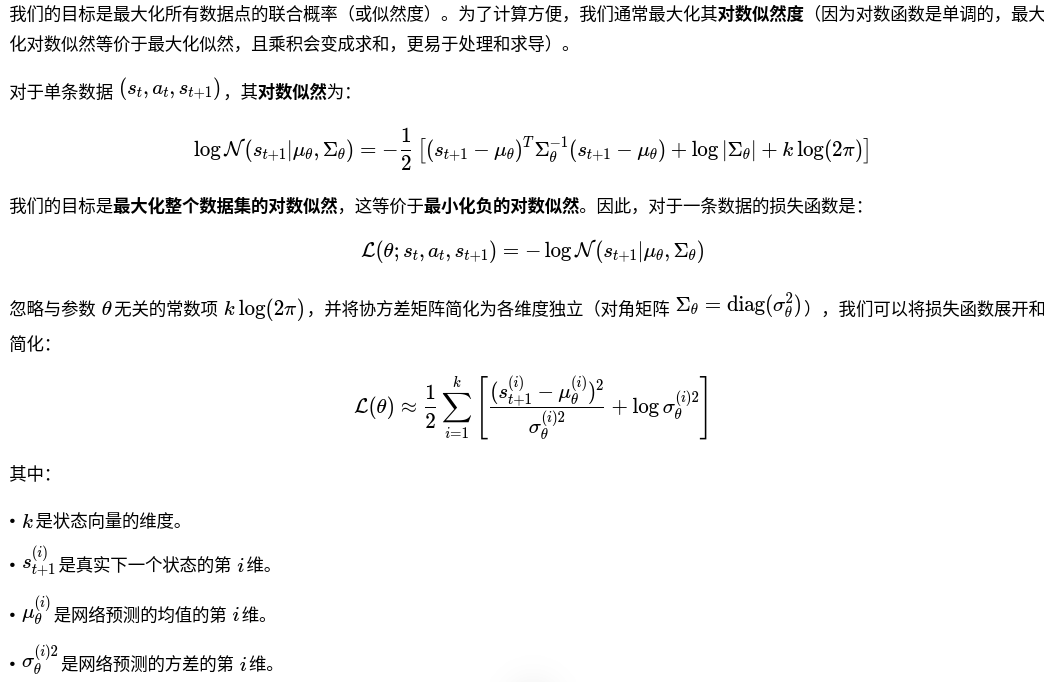

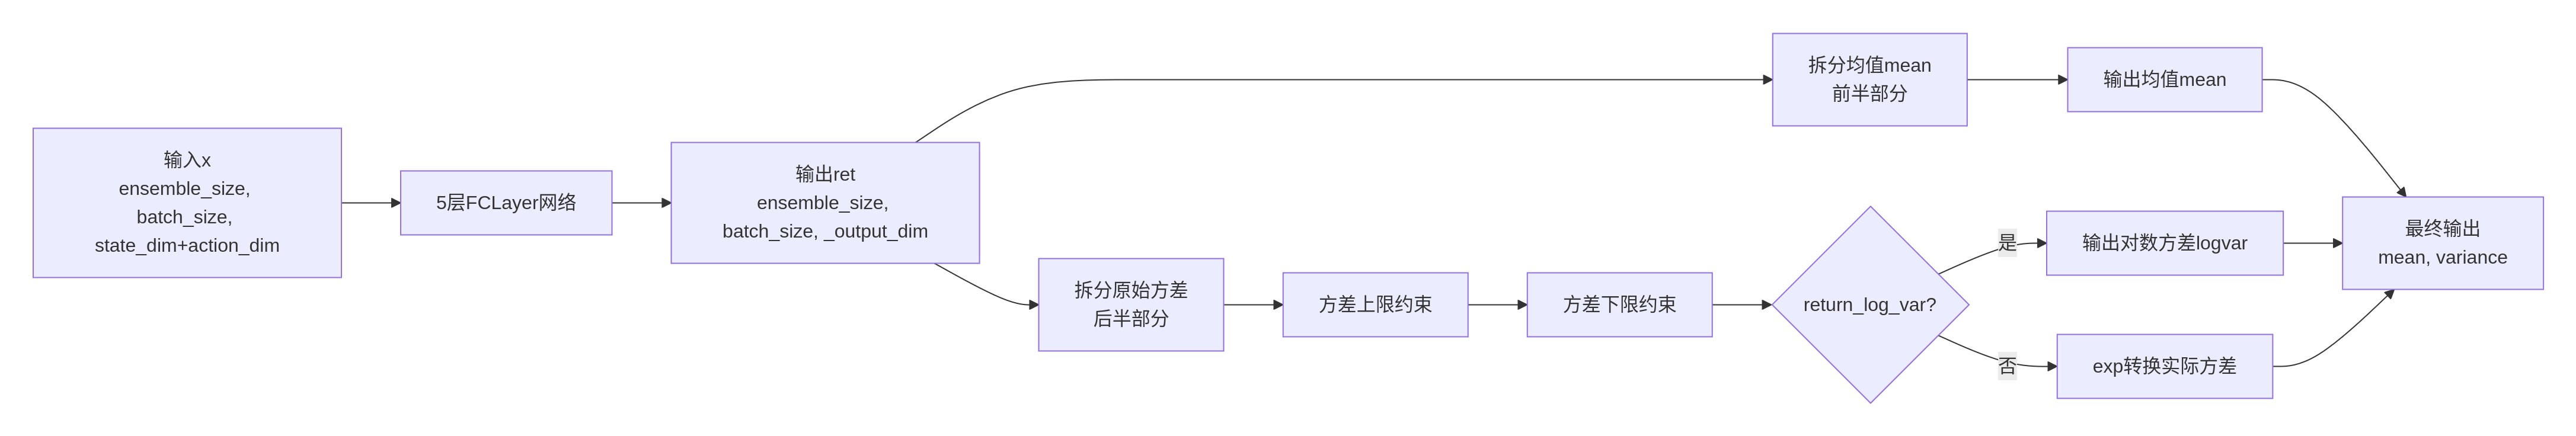

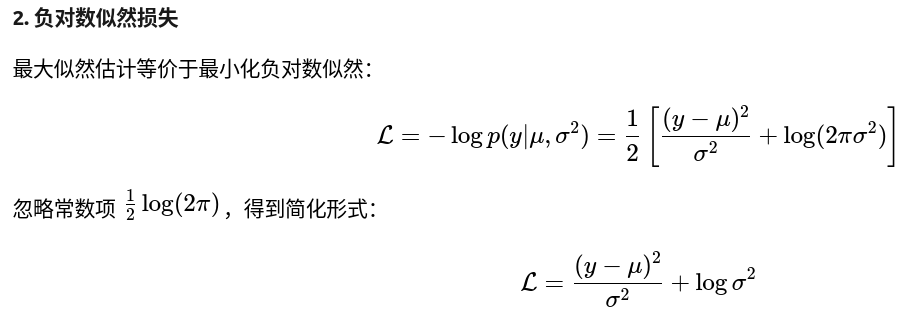  
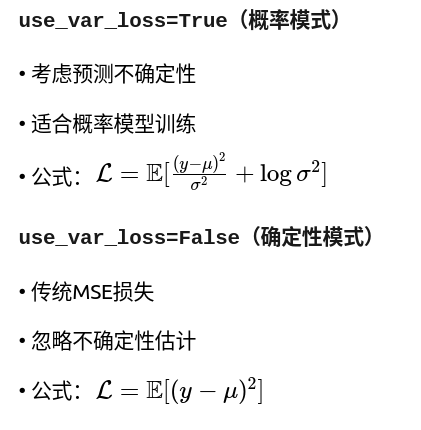  

In [36]:
class EnsembleModel(nn.Module):
    ''' 环境模型集成 '''
    def __init__(self,state_dim,action_dim,ensemble_size=5,learning_rate=1e-3):
        super(EnsembleModel, self).__init__()
        # action_dim可能是(H * a_dim,）,H为规划步数（时间步数）
        # 输出包括均值和方差,因此是状态与奖励维度之和的两倍
        self._output_dim = (state_dim + 1) * 2
        self._max_logvar = nn.Parameter((torch.ones(
            (1, self._output_dim // 2)).float() / 2).to(device),requires_grad=False)
        # 全是0.5的形状为(1,output_dim/2)的张量参数
        self._min_logvar = nn.Parameter((-torch.ones(
            (1, self._output_dim // 2)).float() * 10).to(device),requires_grad=False)
        # 全是-10的形状为(1,output_dim/2)的张量参数
        self.layer1 = FCLayer(state_dim + action_dim, 200, ensemble_size,Swish())
        self.layer2 = FCLayer(200, 200, ensemble_size, Swish())
        self.layer3 = FCLayer(200, 200, ensemble_size, Swish())
        self.layer4 = FCLayer(200, 200, ensemble_size, Swish())
        self.layer5 = FCLayer(200, self._output_dim, ensemble_size,nn.Identity())
        self.apply(init_weights)  # 初始化环境模型中的参数
        self.optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, x, return_log_var=False):
        # (ensemble_size, batch_size, state_dim+action_dim)-> (ensemble_size, batch_size, _output_dim)
        ret = self.layer5(self.layer4(self.layer3(self.layer2(self.layer1(x)))))
        mean = ret[:, :, :self._output_dim // 2]#前半部分
        # mean的形状: (ensemble_size, batch_size, state_dim + 1)
        # 在PETS算法中,将方差控制在最小值和最大值之间
        # softplus：ln(1 + e^x)
        # y=M-|M-x|，当x远大于M时，y=2M-x；当x远小于M时，y=x
        logvar = self._max_logvar - F.softplus(
            self._max_logvar - ret[:, :, self._output_dim // 2:])#后半部分
        # z=m+|y-m|,当y远大于m时，z=y；当y远小于m时，z=2m-y
        logvar = self._min_logvar + F.softplus(logvar - self._min_logvar)
        # self._max_logvar ≥ logvar ≥ self._min_logvar 
        return mean, logvar if return_log_var else torch.exp(logvar)
        # mean的形状: (ensemble_size, batch_size, state_dim + 1)
        # logvar的形状: (ensemble_size, batch_size, state_dim + 1)

    def loss(self, mean, logvar, labels, use_var_loss=True):
        inverse_var = torch.exp(-logvar)
        if use_var_loss:
            # 首先是在状态+奖励维度(state_dim + 1)上求均值(不是求和，为了正则化，平衡与奖励维度的损失)，然后在批量维度(batch_size)上求均值
            mse_loss = torch.mean(torch.mean(torch.pow(mean - labels, 2) *inverse_var,dim=-1),dim=-1)
            # (ensemble_size,)
            var_loss = torch.mean(torch.mean(logvar, dim=-1), dim=-1)
            # (ensemble_size,)
            total_loss = torch.sum(mse_loss) + torch.sum(var_loss)
            # 标量
        else:
            # 一次性沿多个维度求平均
            mse_loss = torch.mean(torch.pow(mean - labels, 2), dim=(1, 2))
            # (ensemble_size,)
            total_loss = torch.sum(mse_loss)
            # 标量
        return total_loss, mse_loss
        # 标量  (ensemble_size,)
    def train(self, loss):
        self.optimizer.zero_grad()
        loss += 0.01 * torch.sum(self._max_logvar) - 0.01 * torch.sum(self._min_logvar)
        loss.backward()
        self.optimizer.step()

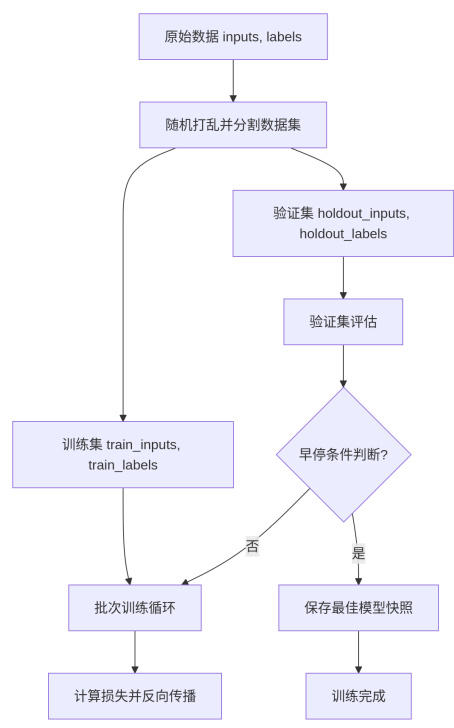
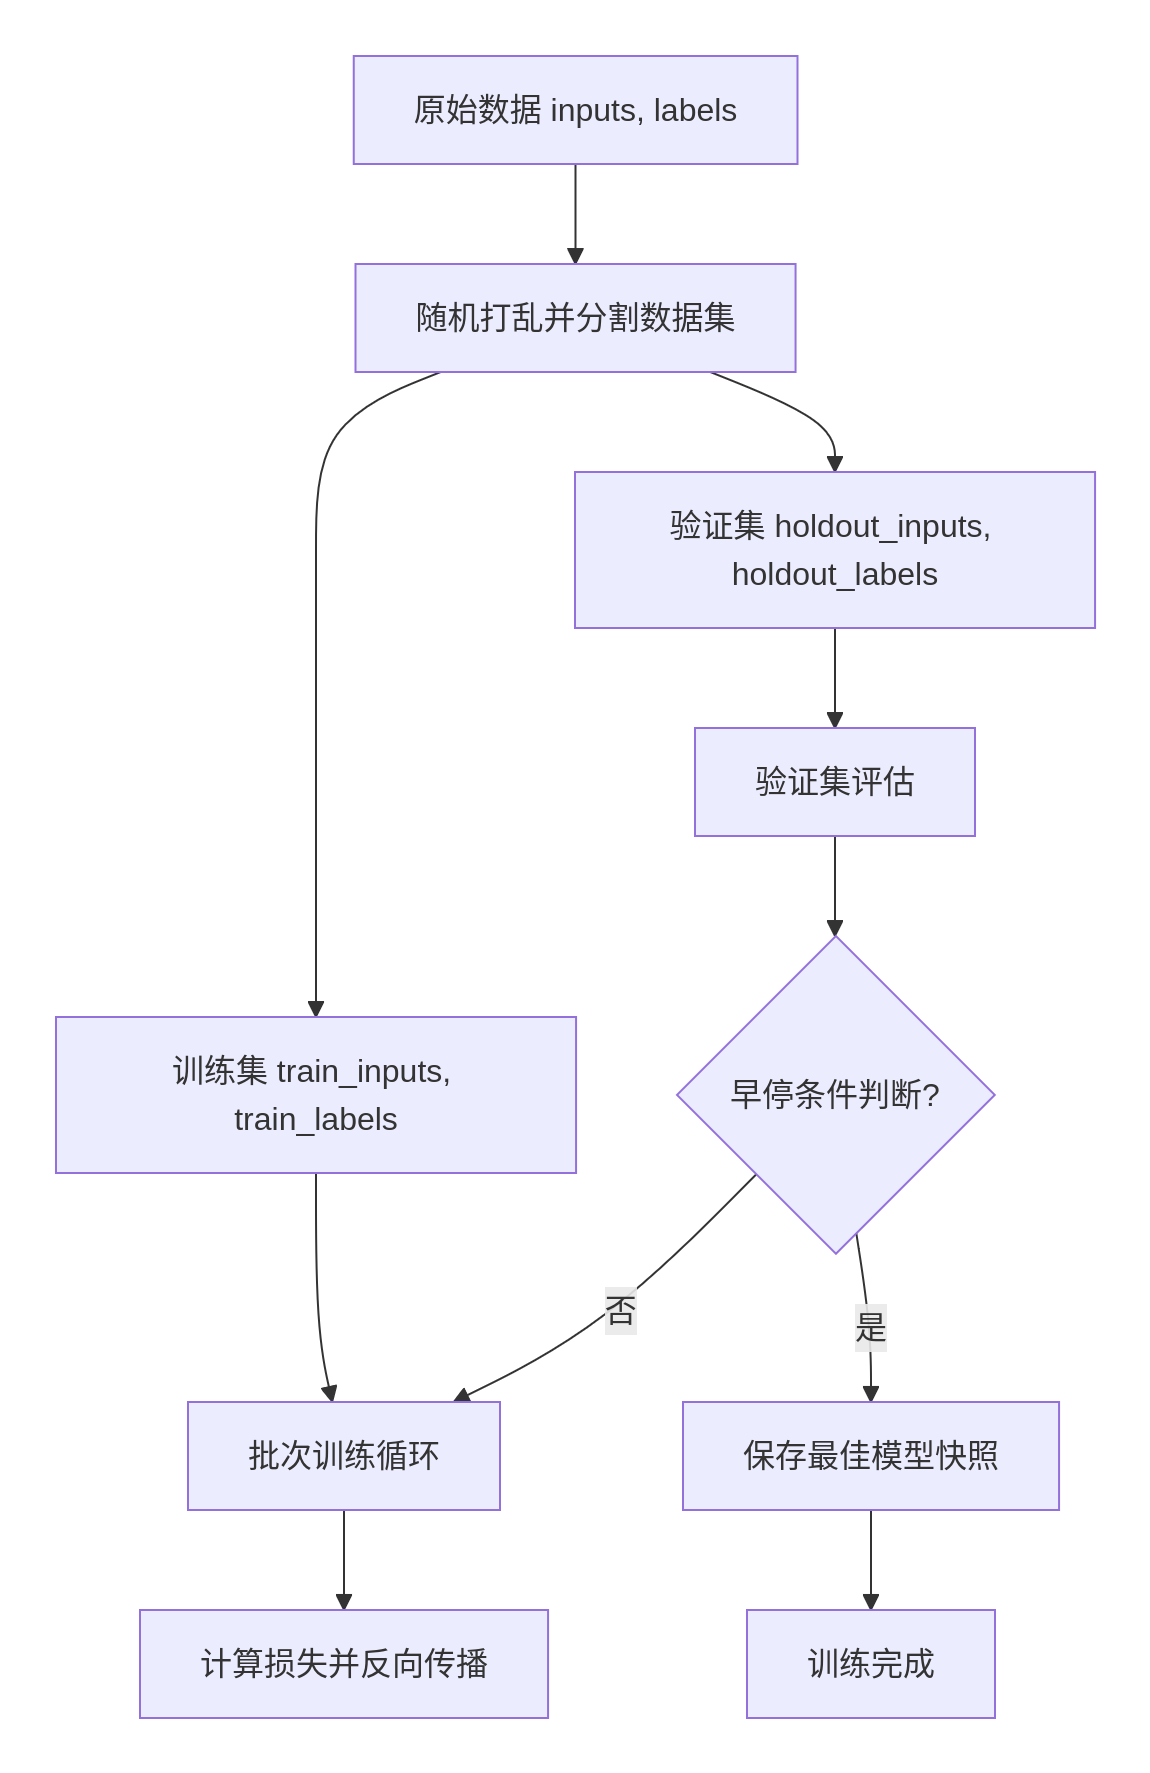

In [37]:
class EnsembleDynamicsModel:
    ''' 环境模型集成,加入精细化的训练 '''
    def __init__(self, state_dim, action_dim, num_network=5):
        self._num_network = num_network
        self._state_dim, self._action_dim = state_dim, action_dim
        self.model = EnsembleModel(state_dim,action_dim,ensemble_size=num_network)
        self._epoch_since_last_update = 0

    def train(self,
              inputs,
              labels,
              batch_size=64,
              holdout_ratio=0.1,
              max_iter=20):
        # 设置训练集与验证集
        # 随机打乱数据
        permutation = np.random.permutation(inputs.shape[0])
        inputs, labels = inputs[permutation], labels[permutation]
        # inputs:(num_samples, state_dim + action_dim)
        # labels:(num_samples, state_dim + 1)
        num_holdout = int(inputs.shape[0] * holdout_ratio)
        train_inputs, train_labels = inputs[num_holdout:], labels[num_holdout:]
        holdout_inputs, holdout_labels = inputs[:num_holdout], labels[: num_holdout]
        holdout_inputs = torch.from_numpy(holdout_inputs).float().to(device)
        holdout_labels = torch.from_numpy(holdout_labels).float().to(device)
        # 扩展维度: (num_holdout, feature_dim) ->(1，num_holdout, feature_dim) -> (num_network, num_holdout, feature_dim)
        # 先广播，再重复
        holdout_inputs = holdout_inputs[None, :, :].repeat([self._num_network, 1, 1])
        holdout_labels = holdout_labels[None, :, :].repeat([self._num_network, 1, 1])
        # 保留最好的结果(num_network,2),为每个集成网络保存(最佳epoch, 最佳验证损失)
        self._snapshots = {i: (None, 1e10) for i in range(self._num_network)}
        for epoch in itertools.count():
            # 定义每一个网络的训练数据,为每个网络生成独立的批次索引
            train_index = np.vstack([
                np.random.permutation(train_inputs.shape[0])
                for _ in range(self._num_network)
            ])# 二维列表，在第一个维度堆叠(num_network, num_train_samples)
            # 所有真实数据都用来训练
            for batch_start_pos in range(0, train_inputs.shape[0], batch_size):
                # (num_network, batch_size)
                batch_index = train_index[:, batch_start_pos: (batch_start_pos +batch_size)]
                # 二维索引
                train_input = torch.from_numpy(train_inputs[batch_index]).float().to(device)
                train_label = torch.from_numpy(train_labels[batch_index]).float().to(device)
                mean, logvar = self.model(train_input, return_log_var=True)
                # (num_network, batch_size, feature_dim)
                loss, _ = self.model.loss(mean, logvar, train_label)
                # 标量  (ensemble_size,)
                self.model.train(loss)
                
            with torch.no_grad():
                mean, logvar = self.model(holdout_inputs, return_log_var=True)
                _, holdout_losses = self.model.loss(mean,logvar,holdout_labels,use_var_loss=False)
                # 标量  (ensemble_size,)
                holdout_losses = holdout_losses.cpu()
                break_condition = self._save_best(epoch, holdout_losses)
                if break_condition or epoch > max_iter:  # 结束训练
                    break

    def _save_best(self, epoch, losses, threshold=0.1):
        # losses:  (ensemble_size,)
        updated = False
        for i in range(len(losses)):
            current = losses[i]
            # {network_index: (best_epoch, best_loss)}
            _, best = self._snapshots[i]
            improvement = (best - current) / best
            if improvement > threshold:
                self._snapshots[i] = (epoch, current)
                updated = True
        self._epoch_since_last_update = 0 if updated else self._epoch_since_last_update + 1
        return self._epoch_since_last_update > 5
        # 超过5个epoch没有提升则返回True

    def predict(self, inputs, batch_size=64):
        # (num_samples, state_dim + action_dim)
        mean, var = [], []
        for i in range(0, inputs.shape[0], batch_size):
            # (batch_size, state_dim + action_dim)
            input = torch.from_numpy(inputs[i:min(i +batch_size, inputs.shape[0])]).float().to(device)
            # 广播给每个网络，输入(1,batch_size, state_dim + action_dim),输出(num_network, batch_size, out_feature_dim)
            cur_mean, cur_var = self.model(input[None, :, :].repeat([self._num_network, 1, 1]),return_log_var=False)
            mean.append(cur_mean.detach().cpu().numpy())
            var.append(cur_var.detach().cpu().numpy())
        # mean的形状: num_samples/batch_size个(num_network, batch_size, out_feature_dim)
        # var的形状: num_samples/batch_size个(num_network, batch_size, out_feature_dim)
        return np.hstack(mean), np.hstack(var)
        # 沿第二个维度batch_size拼接
        # (num_network, num_samples, out_feature_dim)
    

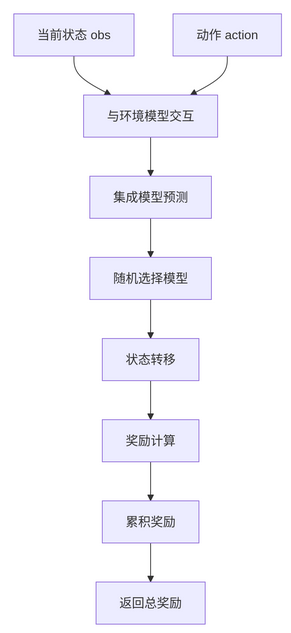

In [38]:
class FakeEnv:
    def __init__(self, model):
        self.model = model

    def step(self, obs, act):
        # (batch_size, state_dim + action_dim)
        inputs = np.concatenate((obs, act), axis=-1)
        # (num_network, batch_size, state_dim +1)
        ensemble_model_means, ensemble_model_vars = self.model.predict(inputs)
        # 只对状态部分（索引1:）进行转换，奖励部分（索引0）保持不变，
        ensemble_model_means[:, :, 1:] += obs.numpy()
        # ensemble_model_means形状还是(num_network, batch_size, state_dim +1)
        # 将状态增量转换为绝对状态
        ensemble_model_stds = np.sqrt(ensemble_model_vars)
        # 从高斯分布中采样，考虑预测不确定性
        ensemble_samples = ensemble_model_means + np.random.normal(
            size=ensemble_model_means.shape) * ensemble_model_stds
        
        # (num_network, batch_size, state_dim+1)
        num_models, batch_size, _ = ensemble_model_means.shape
        models_to_use = np.random.choice(
            [i for i in range(self.model._num_network)], size=batch_size)
        batch_inds = np.arange(0, batch_size)
        samples = ensemble_samples[models_to_use, batch_inds]
        # (batch_size, state_dim + 1)
        rewards, next_obs = samples[:, :1], samples[:, 1:]
        return rewards, next_obs

    def propagate(self, obs, actions):
        # (batch_size, state_dim),(batch_size,time_step, action_dim)
        with torch.no_grad():
            obs = np.copy(obs)
            # (batch_size, 1)
            total_reward = np.expand_dims(np.zeros(obs.shape[0]), axis=-1)
            obs, actions = torch.as_tensor(obs), torch.as_tensor(actions)
            for i in range(actions.shape[1]):#遍历时间步
                action = torch.unsqueeze(actions[:, i], 1)
                # (batch_size,1, action_dim)->(batch_size, action_dim)
                rewards, next_obs = self.step(obs, action)
                total_reward += rewards
                obs = torch.as_tensor(next_obs)
            return total_reward

In [39]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def size(self):
        return len(self.buffer)

    def return_all_samples(self):
        all_transitions = list(self.buffer)
        state, action, reward, next_state, done = zip(*all_transitions)
        return np.array(state), action, reward, np.array(next_state), done

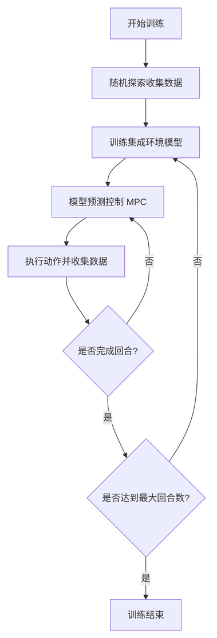  
时间步t: $[a_t, a_{t+1}, a_{t+2}, ..., a_{t+H-1}]$  # 优化得到的动作序列  
执行: $a_t$  
时间步t+1: $[a_{t+1}, a_{t+2}, ..., a_{t+H-1}, 0]$  # 滚动规划初始化  

In [ ]:
class PETS:
    ''' PETS算法 '''
    def __init__(self, env, replay_buffer, n_sequence, elite_ratio,
                 plan_horizon, num_episodes):
        self._env = env
        self._env_pool = replay_buffer

        obs_dim = env.observation_space.shape[0]
        self._action_dim = env.action_space.shape[0]
        self._model = EnsembleDynamicsModel(obs_dim, self._action_dim)
        self._fake_env = FakeEnv(self._model)
        self.upper_bound = env.action_space.high[0]
        self.lower_bound = env.action_space.low[0]

        self._cem = CEM(n_sequence, elite_ratio, self._fake_env,
                        self.upper_bound, self.lower_bound)
        self.plan_horizon = plan_horizon
        self.num_episodes = num_episodes

    def train_model(self):
        """ 使用经验池中的数据训练环境模型 """
        env_samples = self._env_pool.return_all_samples()
        obs = env_samples[0]
        actions = np.array(env_samples[1])
        rewards = np.array(env_samples[2]).reshape(-1, 1)
        next_obs = env_samples[3]
        inputs = np.concatenate((obs, actions), axis=-1)
        labels = np.concatenate((rewards, next_obs - obs), axis=-1)
        # 使用的是差值，预测输出增量
        self._model.train(inputs, labels)

    def mpc(self):
        """ 使用训练的环境模型和CEM算法进行模型预测控制，与真实环境交互一个episode采集数据 """
        # 初始化动作序列均值和方差
        mean = np.tile((self.upper_bound + self.lower_bound) / 2.0,self.plan_horizon)
        var = np.tile(np.square(self.upper_bound - self.lower_bound) / 16,self.plan_horizon)
        # (action_dim,)->(H * action_dim,),H为规划步数（时间步数）
        obs, done, episode_return = self._env.reset()[0], False, 0

        while not done:
            actions = self._cem.optimize(obs, mean, var)
            # (H * a_dim,)
            action = actions[:self._action_dim]  # 选取第一个动作
            next_obs, reward, done, trancated,_ = self._env.step(action)
            done = done or trancated
            self._env_pool.add(obs, action, reward, next_obs, done)
            obs = next_obs
            episode_return += reward
            # 滚动规划：使用剩余动作序列初始化下一次优化
            mean = np.concatenate([
                np.copy(actions)[self._action_dim:],
                np.zeros(self._action_dim)
            ])
            # 一维(H * action_dim,)
        return episode_return

    def explore(self):
        obs, done, episode_return = self._env.reset()[0], False, 0
        while not done:
            action = self._env.action_space.sample()
            next_obs, reward, done,truncated , _ = self._env.step(action)
            # 有些环境没有done，时间到了truncated为true
            done = done or truncated
            self._env_pool.add(obs, action, reward, next_obs, done)
            obs = next_obs
            episode_return += reward
        return episode_return

    def train(self):
        return_list = []
        explore_return = self.explore()  # 先进行随机策略的探索来收集一条序列的数据
        print('episode: 1, return: %d' % explore_return)
        return_list.append(explore_return)

        for i_episode in range(self.num_episodes - 1):
            self.train_model()
            # 从经验池拿出数据训练环境模型，以供CEM算法优化控制指令
            episode_return = self.mpc()
            # 使用环境模型，基于cem优化选择动作的模型预测控制
            return_list.append(episode_return)
            print('episode: %d, return: %d' % (i_episode + 2, episode_return))
        return return_list

In [46]:
buffer_size = 100000
n_sequence = 50
elite_ratio = 0.2
plan_horizon = 25
num_episodes = 30
env_name = 'Pendulum-v1'
env = gym.make(env_name)
env.reset(seed=0)
replay_buffer = ReplayBuffer(buffer_size)
pets = PETS(env, replay_buffer, n_sequence, elite_ratio, plan_horizon,
            num_episodes)

return_list = pets.train()


episode: 1, return: -1781
episode: 2, return: -1397
episode: 3, return: -968
episode: 4, return: -983
episode: 5, return: -1381
episode: 6, return: -1628
episode: 7, return: -885
episode: 8, return: -1219
episode: 9, return: -862
episode: 10, return: -1097
episode: 11, return: -1004
episode: 12, return: -878
episode: 13, return: -722
episode: 14, return: -122
episode: 15, return: -123
episode: 16, return: -253
episode: 17, return: -1
episode: 18, return: -1
episode: 19, return: -282
episode: 20, return: -127
episode: 21, return: -126
episode: 22, return: -126
episode: 23, return: -121
episode: 24, return: -268
episode: 25, return: -122
episode: 26, return: -261
episode: 27, return: -122
episode: 28, return: -2
episode: 29, return: -118
episode: 30, return: -124


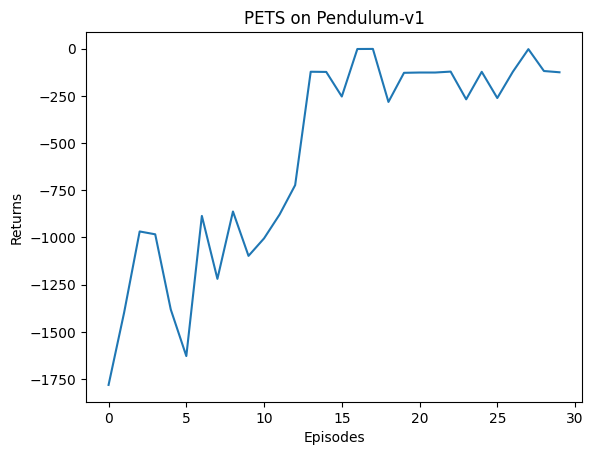

In [47]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PETS on {}'.format(env_name))
plt.show()